In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

import scipy
from scipy.io import netcdf_file
from scipy.constants import mu_0

import copy
import sys
import functools
import pickle
import time
#import pdb

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign, vmap
from desc.backend import jit, odeint,

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.equilibrium import EquilibriaFamily, Equilibrium

from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective

from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison
from desc.plotting import *

from desc.transform import Transform
#from desc.vmec import VMECIO
#from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface, FourierRZCurve
#from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec

from desc.utils import flatten_list, Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

from desc.compute.utils import cross
from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField

from scipy.linalg import null_space
from numpy import ndarray

from desc.fns_simp import (plot_figure, plot_figure2,)

In [ ]:
from desc.objectives import (
        ForceBalance,
        ObjectiveFunction, 
        QuasisymmetryTwoTerm,
        GenericObjective,
        FixPressure,
        FixCurrent,
        HarmonicField_to_BiotSavart,
        #QuasisymmetryBoozer,
        #QuasisymmetryTripleProduct,
        #FixPsi, 
        #FixBoundaryR,
        #FixBoundaryZ,
        #FixIota, 
        #get_fixed_boundary_constraints,
        #RotationalTransform, 
        #AspectRatio,
        #Shear,
        )

from desc.optimize import Optimizer
from desc.plotting import *

In [3]:
# Let's start the iterations with PQA as the initial guess. 
eq = desc.examples.get('precise_QA')

In [ ]:
# create the constant offset surface
surf_winding = eq.surface.constant_offset_surface(offset=0.1, # desired offset
                                             M=16, # Poloidal resolution of desired offset surface
                                             N=8, # Toroidal resolution of desired offset surface
                                             grid=LinearGrid(M=32,
                                                             N=16,
                                                             NFP=eq.NFP)
                                            ) # grid of points on base surface to evaluate unit normal and find points on offset surface,
                                              # generally should be twice the desired resolution


In [ ]:
# No need to define attributes for the initial guess since they have been defined already

# Next, we calculate the initial equilibrium
#NL = 11
#grid = LinearGrid(L = NL, M=0, N=0)
#rho = np.linspace(0, 1, NL+1)

#current_profile = SplineProfile(np.zeros((NL+1, )), knots=rho)
#pressure_profile = SplineProfile(np.zeros((NL+1, )), knots=rho)

#eq = Equilibrium(
#    L=Lres,  # radial resolution
#    M=Mres,  # poloidal resolution
#    N=Nres,  # toroidal resolution
#    surface=surface,
#    pressure=pressure_profile,
#    current=current_profile,
#    Psi=np.pi*(minor_radius)**2,  # total flux, in Webers
#)

#objective = ObjectiveFunction(ForceBalance(eq=eq_nfp1))

In [ ]:
constraints = (
        FixPressure(eq=eq_nfp1),
        FixCurrent(eq=eq_nfp1),
        #FixPsi(eq=eq_nfp1),
        #FixBoundaryR(eq=eq_nfp1),
        #FixBoundaryZ(eq=eq_nfp1),
        )

In [ ]:
modes_R = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
                    )
    
modes_Z = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) >  k, :
    ]

#QS_grid = LinearGrid(M =int(1.5*eq.M_grid), N=int(1.5*eq.N_grid), NFP=eq.NFP, rho=np.array([0.2, 0.4, 0.6]), sym=True)
#jacobian_grid = LinearGrid(L = eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP) 

In [ ]:
# Modes for current potential
basis_M = 10
basis_N = 10

# Find surface current K_s
surface_current_field = FourierCurrentPotentialField.from_surface(surf_winding,
                                                                  M_Phi=basis_M,
                                                                  N_Phi=basis_N,
                                                                  #sym_Phi = True
                                                                 )

surface_current_field.G = 5e6, # Net enclosed poloidal current

#surface_current_field.I = np.load('I.npy')
#surface_current_field.Phi_mn = np.load('phi_mn.npy')

In [ ]:
# Plasma grid
egrid = LinearGrid(M = 10, N = 10, 
                   #NFP = eq.NFP
                  )

# Coil grid
sgrid = LinearGrid(M = 15, N = 15, 
                   #NFP = eq.NFP
                  )

In [ ]:
objectives = ObjectiveFunction((HarmonicField_to_BiotSavart(eq = eq,
                                                            field = surface_current_field,
                                                            curve = ,
                                                            #G = 5e6, # Net enclosed poloidal current
                                                            #surface,
                                                            #target=None,
                                                            #bounds=None,
                                                            #weight=1,
                                                            #deriv_mode="auto",
                                                            surface_grid = sgrid,
                                                            plasma_grid = egrid,
                                                            curve_grid = egrid,
                                                            #use_softmin = False,
                                                            #surface_fixed = False,
                                                            alpha = 1.0,
                                                           ),
                                #QuasisymmetryTwoTerm(eq=eq, helicity=target_helicity, grid=QS_grid, weight=2e2),
                                #ForceBalance(eq=eq, weight=2e6, normalize=True),
                                #GenericObjective(f="sqrt(g)", eq=eq, grid=jacobian_grid, bounds=(0, np.inf), weigh
                                #QuasisymmetryTripleProduct(eq=eq, grid=QS_grid, weight=2e-2),
                                #AspectRatio(eq=eq, bounds=(7, 20), weight=3e2),
                                ))

In [ ]:
constraints = (
            ForceBalance(eq=eq, weight=eq_weight, normalize=True),
            FixPressure(eq=eq),
            FixCurrent(eq=eq),
            #FixPsi(eq=eq),
            #FixBoundaryR(eq=eq, modes=modes_R),
            #FixBoundaryZ(eq=eq, modes=modes_Z),
            )

In [ ]:
optimizer = Optimizer("proximal-lsq-exact")
#optimizer = Optimizer("lsq-exact")
#optimizer = Optimizer("lsq-auglag")
#optimizer = Optimizer("proximal-scipy-trf")
#optimizer = Optimizer("proximal-lsq-auglag")
#optimizer = Optimizer("proximal-sgd")
#pdb.set_trace()

In [ ]:
(eq, curve), _ = optimizer.optimize(
                (eq, curve),
                objectives,
                constraints,
                ftol=1e-5,
                gtol=1e-6,
                xtol=1e-6,
                maxiter=30,
                verbose=3,
                )

In [ ]:
#eq.save(f"/scratch/gpfs/rg6256/umbilic_new_idea/eq_limiota_m{m}_n{n}_L{Lres}_M{Mres}_N{Nres}_{QS_type}_init.h5")
eq.save("eq_soln")

In [5]:
test1 = eq.compute(["H_1"],grid = egrid)["H_1"]

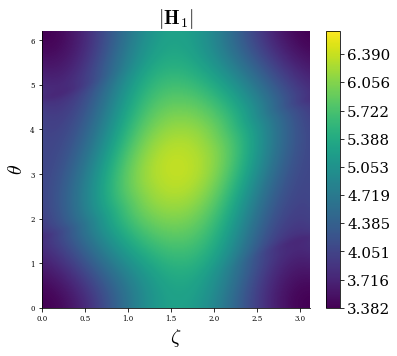

In [6]:
plot_figure(dot(test1,test1)**(1/2),egrid,'$|\mathbf{H}_1|$')

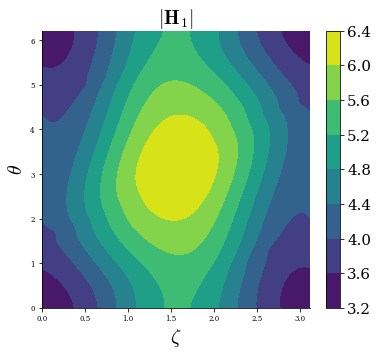

In [7]:
plot_figure2(dot(test1,test1)**(1/2),egrid,'$|\mathbf{H}_1|$')